# En pratique, on cherche un modèle à la fois sensible et spécifique .

In [30]:
import sys, os
sys.path.append(os.path.abspath('../'))  # permet d’accéder au dossier parent
from src.utils.imports import *

In [31]:
df = pd.read_csv(r"C:\Users\kadas\Desktop\Fraude\fraudflow\data\creditcard.csv")

# Regression logistique

In [32]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [33]:
df=df[["V14","V18","V7","V4","V11","V12","V10","V16","V3","V17","V9","V2","Class", "Amount","Time"]]

In [34]:
# Features et cible
X = df.drop(columns=["Class", "Amount"])
y = df["Class"]

In [35]:
# 2️ Séparation Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=90
)

In [36]:
# 3. Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [37]:
# 4. Modèle
model = LogisticRegression(
    max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=90
)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,90
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [38]:
# Récupérer les colonnes originales
feature_names = X_train.columns

# Créer un DataFrame des coefficients
coefs = pd.DataFrame({
    "variable": feature_names,
    "coefficient": model.coef_[0]
})

# Trier par importance absolue
coefs["abs_coef"] = coefs["coefficient"].abs()
coefs = coefs.sort_values(by="abs_coef", ascending=False)

# Afficher les plus influentes
print(coefs.head(16))


   variable  coefficient  abs_coef
3        V4       1.1100    1.1100
0       V14      -0.7428    0.7428
5       V12      -0.5897    0.5897
8        V3      -0.4636    0.4636
7       V16      -0.4379    0.4379
6       V10      -0.3912    0.3912
4       V11       0.2840    0.2840
9       V17      -0.1680    0.1680
10       V9      -0.1275    0.1275
12     Time      -0.1211    0.1211
2        V7      -0.0752    0.0752
11       V2      -0.0224    0.0224
1       V18       0.0187    0.0187


In [39]:
print(model.intercept_)

[-2.84478127]


In [40]:
# 5. Prédictions
y_pred       = model.predict(X_test_scaled)
y_proba      = model.predict_proba(X_test_scaled)[:, 1]
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]

In [41]:
# 6. AUPRC train/test
auprc_train = average_precision_score(y_train, y_train_proba)
auprc_test  = average_precision_score(y_test, y_proba)
print(f"AUPRC Train: {auprc_train:.4f} | AUPRC Test: {auprc_test:.4f}")

AUPRC Train: 0.7479 | AUPRC Test: 0.6330


In [42]:
# 7. Rapport classification
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred, digits=4))


Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9997    0.9806    0.9900     56864
           1     0.0698    0.8469    0.1290        98

    accuracy                         0.9803     56962
   macro avg     0.5348    0.9137    0.5595     56962
weighted avg     0.9981    0.9803    0.9886     56962



| **Métrique**             | **Définition courte**                           | **Intérêt principal**                                               |
| ------------------------ | ----------------------------------------------- | ------------------------------------------------------------------- |
| **Accuracy**             | (TP + TN) / Total                               | % de prédictions correctes (⚠️ trompeuse si classes déséquilibrées) |
| **Precision**            | TP / (TP + FP)                                  | Parmi les alertes positives, combien sont vraies                    |
| **Recall (Sensibilité)** | TP / (TP + FN)                                  | Parmi les vrais positifs, combien ont été détectés                  |
| **F1-Score**             | 2 × (Precision × Recall) / (Precision + Recall) | Compromis entre précision et rappel                                 |
| **Specificity**          | TN / (TN + FP)                                  | Capacité à reconnaître les non-fraudes                              |
| **AUPRC**                | Aire sous la courbe Precision-Recall            | Mesure globale sur classes déséquilibrées                           |
| **ROC-AUC**              | Aire sous la courbe ROC (TPR vs FPR)            | Qualité globale (⚠️ peu utile si fort déséquilibre)                 |
| **Support**              | Nombre d’échantillons par classe                | Sert de pondération dans les moyennes                               |


Accuracy = 0.978 ne veut rien dire ici, car 99 % des transactions sont normales.

Le modèle de régression logistique détecte 87,8 % des fraudes (rappel élevé) mais avec une précision faible (6,5 %), ce qui signifie qu’il génère beaucoup de fausses alertes — typique pour un modèle initial sur données très déséquilibrées.
L’AUPRC est utilisé comme métrique principale car elle reflète mieux la performance globale sur la classe minoritaire.

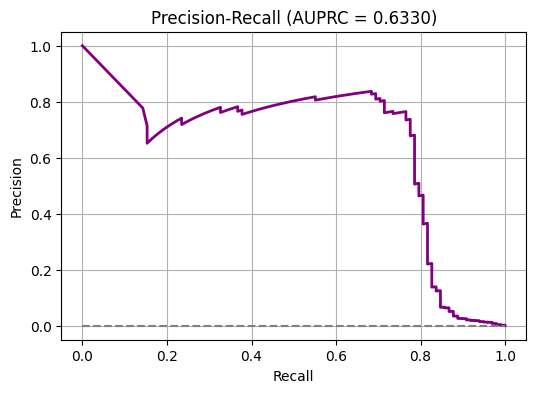

In [43]:
# 8. Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, color='purple', lw=2)
plt.plot([0,1], [np.mean(y_test)]*2, linestyle='--', color='gray')
plt.title(f"Precision-Recall (AUPRC = {auprc_test:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

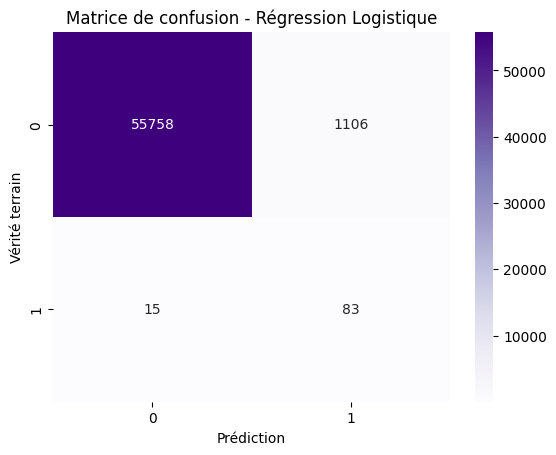

In [44]:
# 9. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Matrice de confusion - Régression Logistique")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

In [46]:
# Extraction des éléments
VN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
VP = cm[1, 1]

# Calcul des métriques
specificite = VN / (VN + FP)
sensibilite = VP / (VP + FN)
precision = VP / (VP + FP)

print(f"Spécificité : {specificite:.4f}")
print(f"Sensibilité (Recall) : {sensibilite:.4f}")
print(f"Précision : {precision:.4f}")

Spécificité : 0.9806
Sensibilité (Recall) : 0.8469
Précision : 0.0698
